In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [22]:
#import data
df = pd.read_csv('loan_data.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Missing Values

In [23]:
#check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [24]:
#impute for missing values
categorical_columns = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term']
for column in categorical_columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)

#double check missing values
missing_values_post_imputation = df.isnull().sum()
print("Missing values after imputation:\n", missing_values_post_imputation)

Missing values after imputation:
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


#### Justification for Imputing Missing Values

Since this assignment requires making loan predictions, I believe that imputing missing values is preferable to dropping missing value rows entirely. The number of missing values in each column is relatively low compared to the overall dataset, so keeping rows by imputing helps preserve data, which helps improve predictions. I chose to impute categorical columns (Gender, Married, Dependents, etc) with their most common values (mode), as this maintains typical distribution patterns for these features. For numerical data like Loan Amount, I used median imputation, as the median is less sensitive to outliers.

### Checking for Outliers

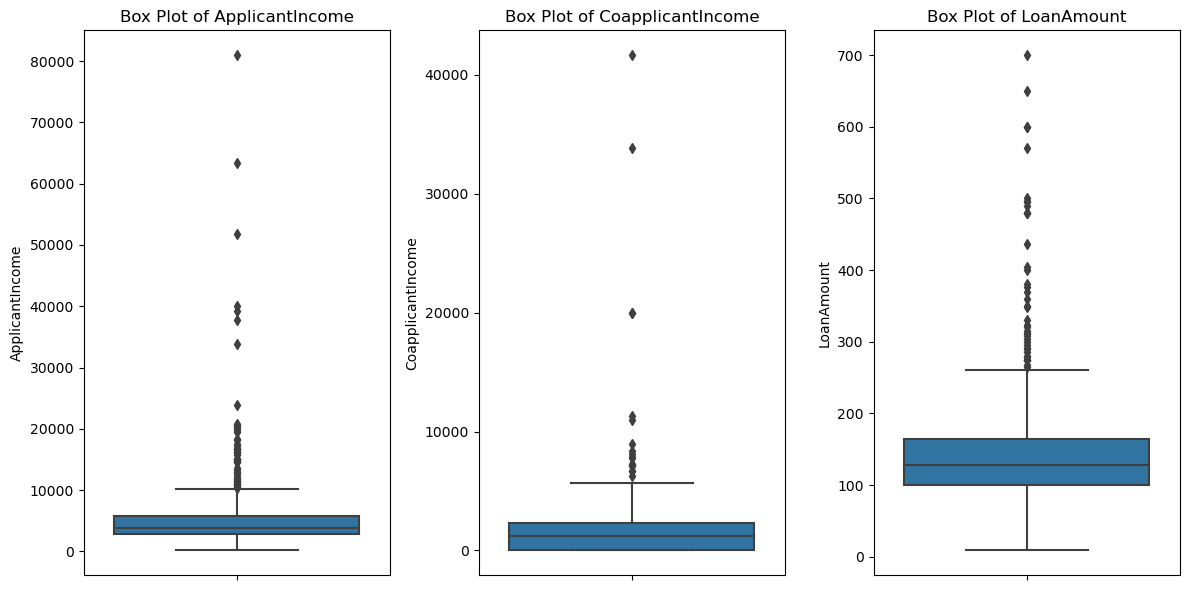

In [6]:
#identifying outliers using IQR
def identify_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

#create graphs for visualization
plt.figure(figsize=(12, 6))
for i, column in enumerate(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=df, y=column)
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

As we can see from the above box plots, there are a number of outliers in the numerical columns.

In [7]:
#shows the outliers in each column and the index of the row.
def print_outliers(column):
    outliers = identify_outliers(column)
    print(f"Outliers in {column}:")
    for idx, value in outliers[column].items():
        print(f"Index: {idx}, {column}: {value}")
    print("\n")

print_outliers('ApplicantIncome')
print_outliers('CoapplicantIncome')
print_outliers('LoanAmount')

Outliers in ApplicantIncome:
Index: 9, ApplicantIncome: 12841
Index: 34, ApplicantIncome: 12500
Index: 54, ApplicantIncome: 11500
Index: 67, ApplicantIncome: 10750
Index: 102, ApplicantIncome: 13650
Index: 106, ApplicantIncome: 11417
Index: 115, ApplicantIncome: 14583
Index: 119, ApplicantIncome: 10408
Index: 126, ApplicantIncome: 23803
Index: 128, ApplicantIncome: 10513
Index: 130, ApplicantIncome: 20166
Index: 138, ApplicantIncome: 14999
Index: 144, ApplicantIncome: 11757
Index: 146, ApplicantIncome: 14866
Index: 155, ApplicantIncome: 39999
Index: 171, ApplicantIncome: 51763
Index: 183, ApplicantIncome: 33846
Index: 185, ApplicantIncome: 39147
Index: 191, ApplicantIncome: 12000
Index: 199, ApplicantIncome: 11000
Index: 254, ApplicantIncome: 16250
Index: 258, ApplicantIncome: 14683
Index: 271, ApplicantIncome: 11146
Index: 278, ApplicantIncome: 14583
Index: 284, ApplicantIncome: 20667
Index: 308, ApplicantIncome: 20233
Index: 324, ApplicantIncome: 15000
Index: 333, ApplicantIncome: 63

As we can see in the above printout and graphs, there are quite a large number of outliers. However, I believe the correct option is to keep the outliers in the dataset. The three columns that were checked are ApplicantIncome, CoapplicantIncome, and LoanAmount. In the real world, there's a large amount of variance in all of these three columns. Different applicants with different incomes have different loans to apply to, so it makes sense that the values would range. Thus, I believe it makes sense to keep the outliers, in order to have a good view of the differences in loan application and acceptance that happens in the real world.

### Discretizing ApplicantIncome, CoapplicantIncome, LoanAmount, and Loan_Amount_Term

In [8]:
#discretizing columns
df['ApplicantIncome'] = pd.cut(df['ApplicantIncome'], 
                                bins=[0, 30000, 80000, float('inf')], 
                                labels=['Low Income', 'Medium Income', 'High Income'])

df['CoapplicantIncome'] = pd.cut(df['CoapplicantIncome'], 
                                  bins=[-1, 0, 15000, 40000, float('inf')], 
                                  labels=['No Co-Applicant', 'Low Income', 'Medium Income', 'High Income'])

df['LoanAmount'] = pd.cut(df['LoanAmount'], 
                          bins=[0, 150, 300, float('inf')], 
                          labels=['Small Loan', 'Medium Loan', 'Large Loan'])

df['Loan_Amount_Term'] = pd.cut(df['Loan_Amount_Term'], 
                                bins=[0, 120,240, float('inf')], 
                                labels=['Short Term', 'Medium Term', 'Long Term'])

#check changes
print(df[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']].head())

  ApplicantIncome CoapplicantIncome  LoanAmount Loan_Amount_Term
0      Low Income   No Co-Applicant  Small Loan        Long Term
1      Low Income        Low Income  Small Loan        Long Term
2      Low Income   No Co-Applicant  Small Loan        Long Term
3      Low Income        Low Income  Small Loan        Long Term
4      Low Income   No Co-Applicant  Small Loan        Long Term


In each of the above columns, I divided the values into a few different categories. For ApplicantIncome, I chose to divide it into Low Income (0 - 30,000), Medium Income (30,001 to 80,000), and High Income (80,001 and above.) This was done to generally imitate income values in the real world, while specifically looking at the average values in this data set.

For CoapplicantIncome, I chose to do effectively the same thing - however, I also added a label for the columns with 0 income, which I believe means that there isn't a coapplicant present. 

For LoanAmount, the divisions between small, medium and large loan were effectively planned around the average of loan amount values. The average for the column was 146.41, which places my values at good markers for what small, medium, and large loans might look like.

Lastly, for Loan_Amount_Term, it wasn't exactly as with the other columns. The terms were of a few set amounts - 84, 120, 180, 240, 360, and 480. Due to this, I broke the loans up into categories, Short (0-120), Medium (121-240) and Long (above 240).

In [9]:
all_columns = df.columns

#excluding 'Loan_Status' from predictors
predictors = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

print("Selected Features for Predictors:")
print(predictors)

df_selected = df[predictors]

print(df_selected.head())

Selected Features for Predictors:
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
  ApplicantIncome CoapplicantIncome  LoanAmount Loan_Amount_Term
0      Low Income   No Co-Applicant  Small Loan        Long Term
1      Low Income        Low Income  Small Loan        Long Term
2      Low Income   No Co-Applicant  Small Loan        Long Term
3      Low Income        Low Income  Small Loan        Long Term
4      Low Income   No Co-Applicant  Small Loan        Long Term


For predicting loan approval, I focused on features that are directly related to financial situations, such as ApplicantIncome, CoapplicantIncome, LoanAmount, and Loan_Amount_Term. I believe that these four show direct involvement in loan prediction, wheras the other features like Gender, MaritalStatus, Dependents, and Education are personal qualities. While these features do impact loan approval in the real world, for my models, I wanted to focus on specifically financial status.

In [10]:
label_encoder = LabelEncoder()

categorical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Loan_Status']

for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

print(df[categorical_columns].head())

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0                1                  3           2                 0   
1                1                  1           2                 0   
2                1                  3           2                 0   
3                1                  1           2                 0   
4                1                  3           2                 0   

   Loan_Status  
0            1  
1            0  
2            1  
3            1  
4            1  


### Training Models

In [14]:
#focusing on just ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_term.
X = df[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']]
y = df['Loan_Status']

#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
#training model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

#predicitng and evaluating
y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
auc_nb = roc_auc_score(y_test, nb_model.predict_proba(X_test)[:, 1])

print("Naive Bayes:")
print(f"  Accuracy: {accuracy_nb:.4f}")
print(f"  AUC Score: {auc_nb:.4f}")

Naive Bayes:
  Accuracy: 0.6341
  AUC Score: 0.5445


In [16]:
#training model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

#predicitng and evaluating
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])

print("Logistic Regression:")
print(f"  Accuracy: {accuracy_lr:.4f}")
print(f"  AUC Score: {auc_lr:.4f}")

Logistic Regression:
  Accuracy: 0.6504
  AUC Score: 0.5576


In [17]:
#training model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

#predicitng and evaluating
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
auc_knn = roc_auc_score(y_test, knn_model.predict_proba(X_test)[:, 1])

print("K-Nearest Neighbors:")
print(f"  Accuracy: {accuracy_knn:.4f}")
print(f"  AUC Score: {auc_knn:.4f}")

K-Nearest Neighbors:
  Accuracy: 0.5854
  AUC Score: 0.5888


I chose to use Naive Bayes, Logistic Regression, and K-Nearest Neighbors, as a way to show off a variety of different modeling approaches. Naive Bayes is a probabilistic  model, Logistic Regression is a linear model, and K-Nearest Neighbor is a non-linear model. Although each of the models do have various weaknesses, most of the weaknesses observed in these models don't apply to this dataset and are overshadowed by their positives. For instance, Logistic Regression is unable to handle a large number of categorical features, but that doesn't really apply to this dataset (we're only looking at 4 of the features). Additionally, each of the models are easy to train and understand.

### Analysis

Among the three models, Logistic Regression achieved the highest accuracy (0.6504) and a reasonably competitive AUC score (0.5576). Although K-Nearest Neighbors (KNN) had a slightly higher AUC (0.5888), its overall accuracy was lower (0.5854), meaning it may not be as reliable for predictions on this dataset. Naive Bayes, with an accuracy of 0.6341 and the lowest AUC (0.5445), also underperformed compared to Logistic Regression.

Logistic Regression seemed to be the most effective model for predicting loan approval status, as it returned the highest accuracy while maintaining a decent AUC score. The strength of this model lies in its simplicity and its ability to generalize across the data without overfitting. Logistic Regression performed better than Naive Bayes, which struggled with the independence assumption of features, and K-Nearest Neighbors, which was sensitive to data distribution and potential outliers, leading to lower accuracy.

While KNN had a marginally higher AUC score, its overall accuracy was lower. In contrast, Logistic Regression provides a good balance, making it suitable for this dataset. Due to its balance and average accuracy scoring, I think that Logistic Regression is good for this task.